In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops
from scipy import stats
from scipy.stats import pearsonr as pearson
import helper_functions as hf

In [ ]:
#Loading seismic using Segyio lib

# string containing the path location of the seismic data at disk
segy_file_path = ""    #<-----------------Nome e caminho para a sismica

f = segyio.open(segy_file_path, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

t = f.samples
il = f.attributes(189)[:]
xl = f.attributes(193)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

nil, nxl, nt = len(ilines), len(xlines), len(t)


(256, 256, 256)
(256, 256, 256)
(256, 256)
(256, 256)


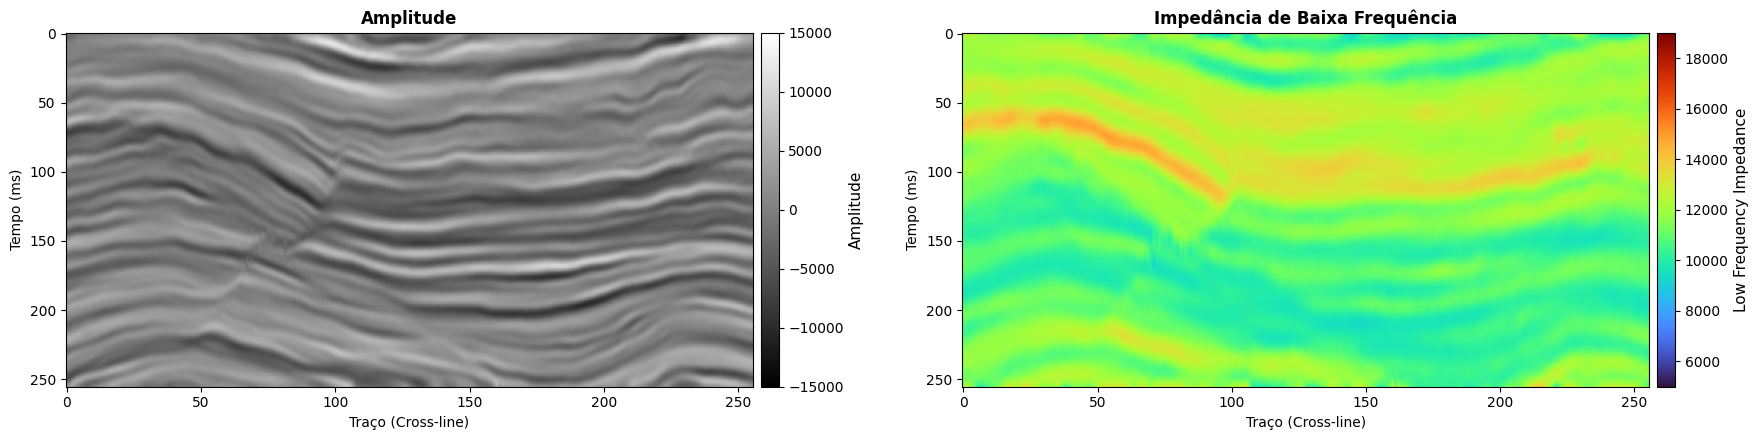

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(18, 4.5))

SECTION = 128

c = axs.imshow(
    d[SECTION, :, :].T, cmap="gray", aspect="auto", vmin=-15000, vmax=15000
)
cbar = fig.colorbar(c, ax=axs, pad=0.01)
cbar.set_label("Amplitude", size=11)
axs.set_title("Amplitude", fontweight="bold")
axs.set_ylabel("Tempo (ms)")
axs.set_xlabel("Traço (Cross-line)")
axs.tick_params(axis="both")
axs.grid(False)


plt.tight_layout()
plt.show()

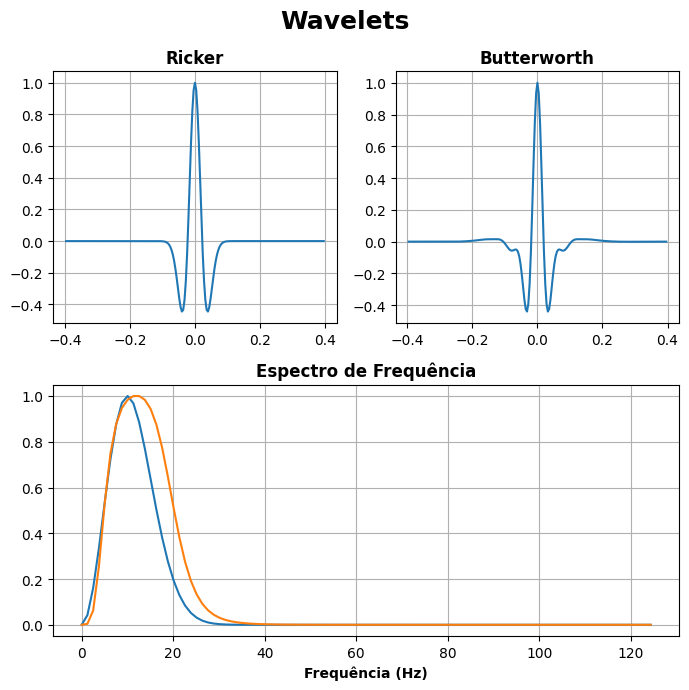

In [5]:
sample = 100
dt = 4
pkfq = 10
highfq = 20
lowfq = 5

twlet, wlet, freqs, fft = hf.generate_ricker(peak_freq=pkfq, samples=sample, dt=dt)
twlet_b, wlet_b, freqs_b, fft_b = hf.generate_butter(
    freq_hi=highfq, freq_low=lowfq, samples=sample, dt=dt
)

plt.figure(figsize=(7, 7))

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet)
plt.tick_params(axis="both")
plt.title("Ricker", fontweight="bold")
plt.grid()

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b)
plt.tick_params(axis="both")
plt.title("Butterworth", fontweight="bold")
plt.grid()

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="both")
plt.plot(freqs, fft, label="Ricker")
plt.title(
    "Espectro de Frequência", fontweight="bold"
)
plt.plot(freqs_b, fft_b, label="Butterworth")
plt.xlabel("Frequência (Hz)", fontweight="bold")
plt.grid()

plt.tight_layout()
plt.show()

Post-stack seismic modelling is the process of constructing seismic post-stack data from a profile of an elastic parameter (Impedance or Velocity) of choice in time (or depth) domain. This can be easily achieved using the following forward model:

$$ d(t, \theta = 0) = w (t) \cdot \frac{d \ln m(t)}{dt} $$

where $m(t)$ is the elastic parameter profile and $w (t)$ is the time domain seismic wavelet. In compact form:

$$ \text{d} = \textbf{WDm} $$

In the special case of acoustic impedance ($m(t) = AI(t)$), the modelling operator can be used to create zero-offset data:

$$ d(t, \theta = 0) = \frac{1}{2} w (t) \cdot \frac{d \ln m(t)}{dt} $$

where the scaling factor $\frac{1}{2}$ can be easily included in the wavelet

In [ ]:
d = d[..., int(2500//dt) : int(4000//dt)]

nx , ny , nz = d.shape

PostStackOperator = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=(ny,), explicit=False
)

c:\Users\Icarl\AppData\Local\Programs\Python\Python313\Lib\site-packages\pylops\utils\signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


Correlação: 0.78


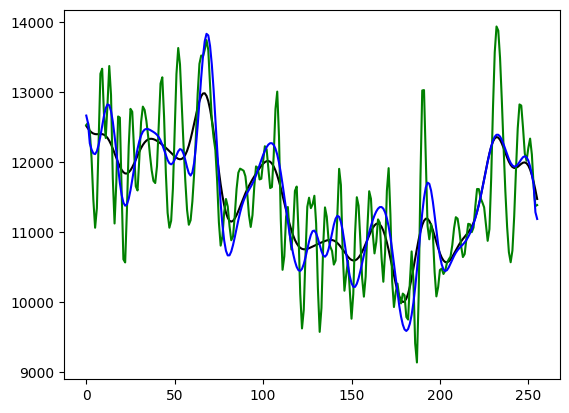

In [ ]:
section_inv = 200

input_data = d[section_inv, ...]

inverted_impedance_ricker = (
    pylops.optimization.leastsquares.normal_equations_inversion(
        Op=PostStackOperator,
        y=d/1e4,
        Regs=[],
        epsI=1e-2,
        x0=np.zeros(input_data.shape),
        engine="scipy",
        **dict(maxiter=1000)
    )[0]
)

In [ ]:
#plotting data
fig, ax = plt.subplots(figsize=(15, 5))

c = ax.imshow(d, cmap='gist_rainbow',vmin=2.2, vmax=3.2,
           extent=(xl[0], xl[-1], 6000, 4600))

plt.axis('tight')
plt.colorbar(c)
plt.ylim(6000, 4600)
plt.grid(False)

In [ ]:
#plotting data
fig, ax = plt.subplots(figsize=(15, 5))

c = ax.imshow(inverted_impedance_ricker, cmap='gist_rainbow',vmin=2.2, vmax=3.2,
           extent=(xl[0], xl[-1], 6000, 4600))

plt.axis('tight')
plt.colorbar(c)
plt.ylim(6000, 4600)
plt.grid(False)